In [1]:
import sys
sys.path.insert(0, '/home/jovyan/braindecode/')
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import mne
from mne.channels import make_standard_montage
from mne.viz import plot_topomap

from braindecode.visualization import compute_amplitude_gradients

from decode_tueg import load_exp, DataScaler, TargetScaler, Augmenter

In [2]:
def add_cbar(fig, ax_img):
    # manually add colorbar
    ax_x_start = 0.95
    ax_x_width = 0.04
    ax_y_start = 0.1
    ax_y_height = 0.9
    cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
    clb = fig.colorbar(ax_img, cax=cbar_ax)
    clb.ax.set_title('uV')

In [3]:
def freq_to_bin(bins, freq):
    return np.abs(bins - freq).argmin()


def freqs_to_bin(bins, freqs):
    return [np.abs(bins - freq).argmin() for freq in freqs]

In [4]:
names = ['A1', 'A2', 'C3', 'C4', 'Cz', 'F3', 'F4', 'F7', 'F8', 'Fp1', 'Fp2',
       'Fz', 'O1', 'O2', 'P3', 'P4', 'Pz', 'T3', 'T4', 'T5', 'T6']

In [5]:
montage = make_standard_montage('standard_1020')
info = mne.create_info(names, 100, ch_types='eeg')
info = info.set_montage(montage)

In [6]:
batch_size = 64
n_recordings = 50
exp_dir = '/home/jovyan/experiments/'
checkpoint = 'train_end'

In [7]:
bands = [(0,4),(4,8),(8,13),(13,30),(30,50)]

In [8]:
clf, data_scaler, target_scaler, config = load_exp(
    exp_dir,
    '2023-02-01T14:42:53.219167/20230201/0',
    checkpoint
)

In [9]:
for ds_name in ['transition']:  # non-pathological, pathological
    break

In [10]:
with open(f'/home/jovyan/longitudinal/{ds_name}_pre_win.pkl', 'rb') as f:
    ds = pickle.load(f)

In [11]:
if n_recordings is not None:
    ds = ds.split(list(range(n_recordings)))['0']

In [12]:
all_grads = {}
for n, d in ds.split('pathological').items():
    grads = compute_amplitude_gradients(clf.module, d, batch_size)
    avg_grads = grads.mean((1, 0))
    all_grads['Non-pathological' if n == '0' else 'Pathological'] = avg_grads
if 'Non-pathological' in all_grads.keys() and 'Pathological' in all_grads.keys():
    all_grads['Non-pathological – Pathological'] = all_grads['Non-pathological'] - all_grads['Pathological']

In [13]:
freqs = np.fft.rfftfreq(ds[0][0].shape[1], 1/ds.datasets[0].windows.info['sfreq'])

In [14]:
freqs.shape, avg_grads.shape

((3001,), (21, 3001))

Non-pathological
(0, 4) -3.4005652e-09 5.8860703e-09
(4, 8) -6.19234e-13 7.8521906e-13
(8, 13) -4.825331e-14 1.5233302e-13
(13, 30) -3.4378028e-14 2.7722748e-14
(30, 50) -3.98399e-14 3.0881717e-14
Pathological
(0, 4) -3.826885e-09 4.0705856e-09
(4, 8) -7.1747236e-13 6.7984187e-13
(8, 13) -9.5732063e-14 2.8263042e-13
(13, 30) -5.2783648e-14 8.500541e-14
(30, 50) -1.786692e-13 9.572839e-14
Non-pathological – Pathological
(0, 4) -2.2011215e-09 1.8154855e-09
(4, 8) -8.787876e-13 1.5026912e-12
(8, 13) -2.4654974e-13 9.1035456e-14
(13, 30) -9.345321e-14 5.5901982e-14
(30, 50) -1.03268604e-13 1.3882932e-13


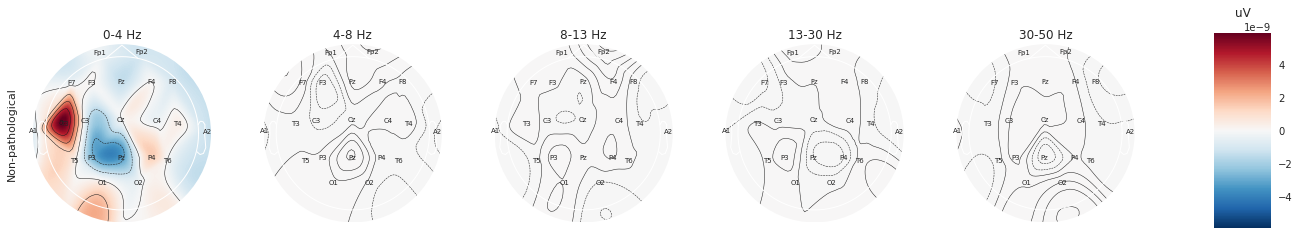

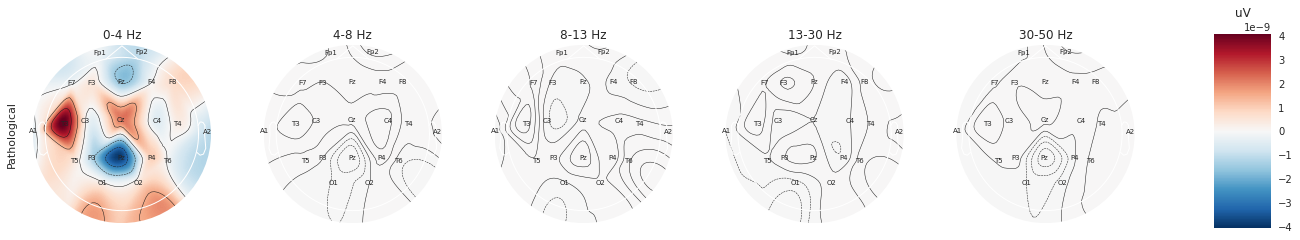

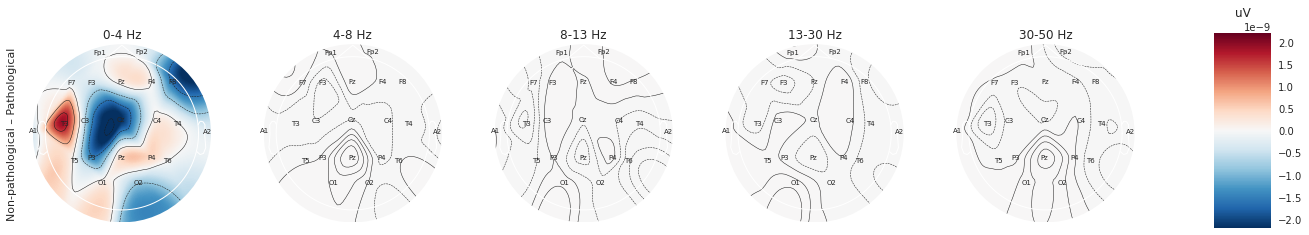

In [17]:
for n, grads in all_grads.items():
    print(n)
    fig, ax_arr = plt.subplots(1, len(bands), figsize=(20, 3))
    # compute all bands gradients
    all_band_grads = []
    for band_i, band in enumerate(bands):
        l, h = freqs_to_bin(freqs, band)
        band_freqs = freqs[l:h+1]
        band_grads = grads[:,l:h+1].mean(axis=1)
        print(band, band_grads.min(), band_grads.max())
        all_band_grads.append(band_grads)
    # for better comparability, compute vlim over all bands
    vmin, vmax = np.min(all_band_grads), np.max(all_band_grads)
    max_abs = np.abs([vmin, vmax]).max()
    # plot all bands gradients
    for band_i, (band, band_grads) in enumerate(zip(bands, all_band_grads)):
        ax_img, contours = plot_topomap(
            band_grads, 
            info,
            size=5,
            names=names,
            show=False,
            axes=ax_arr[band_i],
            vlim=(-max_abs, max_abs),
        )
        ax_img.axes.set_title('-'.join([str(i) for i in band])+' Hz')
        if band_i == 0:
            ax_img.axes.set_ylabel(f'{n}\n')
    add_cbar(fig, ax_img)